In [852]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# import tensorflow as tf
# from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense
from sklearn import preprocessing

from sklearn.model_selection import *
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
import seaborn as sns
from scipy import stats

from models import *

## **Exploratory Data Analysis**

In [1048]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v2.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaTmax', 'DeltaT_logVars'])


In [1050]:
y = np.zeros(124)

x = np.zeros((124, 2*97))
for i, cell in enumerate(data.keys()):
    x[i, :97] = data[cell]["DeltaQ_logVars"][1:]
    #x[i, 97:2*97] = np.log10(-data[cell]["DeltaQ_mins"][1:])
    #x[i, 97:2*97] = data[cell]["DeltaQ_means"][1:]
    #x[i, 97:2*97] = data[cell]["DeltaT_logVars"][1:]
    x[i, 97:2*97] = data[cell]["DeltaTmax"][1:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [1051]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])


In [1053]:
model = AutoEncoder_ElasticNet(n_features=2, n_cycles=97, lr = 4e-5, en_lambda=0.5, epochs=2000)
train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(train)

Epoch 0/2000, loss: 21.10
Epoch 200/2000, loss: 1.16
Epoch 400/2000, loss: 0.65
Epoch 600/2000, loss: 0.52
Epoch 800/2000, loss: 0.84
Epoch 1000/2000, loss: 0.31
Epoch 1200/2000, loss: 0.26
Epoch 1400/2000, loss: 0.23
Epoch 1600/2000, loss: 0.19
Epoch 1800/2000, loss: 0.15


In [1054]:
model.encoder(x[5])

tensor([ 0.0000,  0.0000,  5.8169,  0.0000,  0.0000,  0.0000,  7.1335,  6.6792,
         7.3345,  0.0000,  4.0189, 12.9697,  7.4217,  1.8791,  0.0000,  2.4444,
         0.0000,  1.8792, 10.0428,  0.0000,  5.2733,  1.8005,  5.4630,  4.5900,
         3.2275, 13.3729,  9.0373,  8.9511,  3.4508,  0.0000,  3.1375,  0.0000],
       grad_fn=<ReluBackward0>)

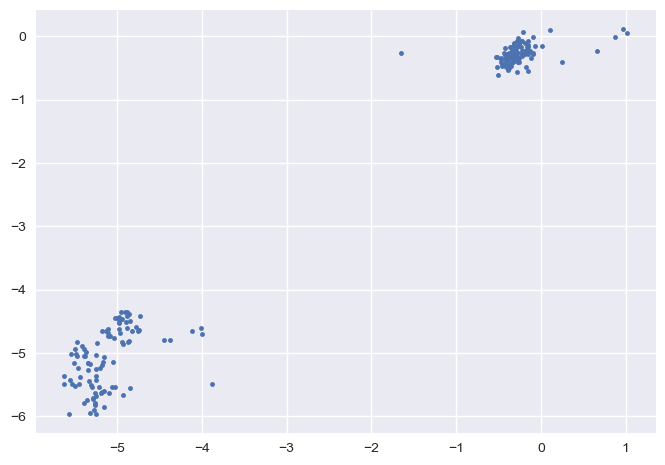

In [1055]:
plt.plot(x[4].detach().numpy(), model.forward(x[4]).detach().numpy(), ".")

In [1056]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.2286], grad_fn=<AddBackward0>)


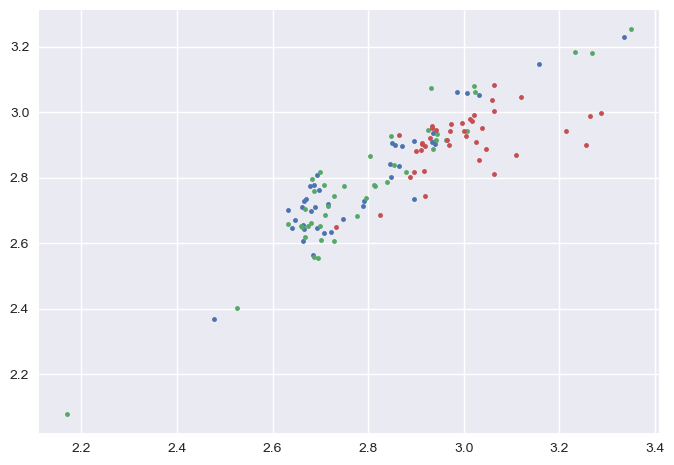

In [1057]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")

# SVR

In [1058]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[0.0000000e+00 0.0000000e+00 7.3944497e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 6.7299123e+00 7.7815619e+00 7.9582081e+00 0.0000000e+00
 3.9408741e+00 1.3493482e+01 8.4294376e+00 1.6924852e+00 0.0000000e+00
 1.8855014e+00 0.0000000e+00 2.3004467e+00 9.8136396e+00 0.0000000e+00
 5.8041368e+00 1.5189352e+00 5.1504240e+00 5.8281097e+00 3.9709184e+00
 1.4079297e+01 9.5196638e+00 9.8009691e+00 3.7142246e+00 0.0000000e+00
 2.8385906e+00 3.9451569e-04]


In [1059]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [1060]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, vdim=1, num_heads=1):
        super(AttentionModel, self).__init__()

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.d_model = d_model

    def reshape_input(self,X):
        return X.reshape(X.shape[0], -1)

    def scaled_dot_product_attention(self, Q, K, V):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
    
    def forward(self, X):
        X = self.reshape_input(X)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        attn_output = self.scaled_dot_product_attention(Q, K, V)
        return attn_output

In [1065]:
# parameters
lr = 0.001
feat_dim = 2*16
d_model = 8
nepoch = 2000
batch_size = 1

In [1066]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [1067]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  658.793 | rmse_test:  746.289 | rmse_stest:  1002.119
Epochs: 100 | rmse:  625.677 | rmse_test:  712.119 | rmse_stest:  960.702
Epochs: 150 | rmse:  558.398 | rmse_test:  602.387 | rmse_stest:  832.810
Epochs: 200 | rmse:  347.677 | rmse_test:  279.599 | rmse_stest:  510.190
Epochs: 250 | rmse:  301.084 | rmse_test:  230.201 | rmse_stest:  394.677
Epochs: 300 | rmse:  281.386 | rmse_test:  186.018 | rmse_stest:  391.952
Epochs: 350 | rmse:  275.556 | rmse_test:  168.691 | rmse_stest:  328.155
Epochs: 400 | rmse:  277.870 | rmse_test:  176.065 | rmse_stest:  368.663
Epochs: 450 | rmse:  269.545 | rmse_test:  155.945 | rmse_stest:  355.288
Epochs: 500 | rmse:  285.805 | rmse_test:  166.352 | rmse_stest:  312.160
Epochs: 550 | rmse:  268.898 | rmse_test:  152.161 | rmse_stest:  318.612
Epochs: 600 | rmse:  267.516 | rmse_test:  144.052 | rmse_stest:  348.049
Epochs: 650 | rmse:  273.202 | rmse_test:  137.183 | rmse_stest:  332.718
Epochs: 700 | rmse:  285.396 | rmse_te

In [1027]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

70.87288226629626
102.18107215307553
324.72437961108614


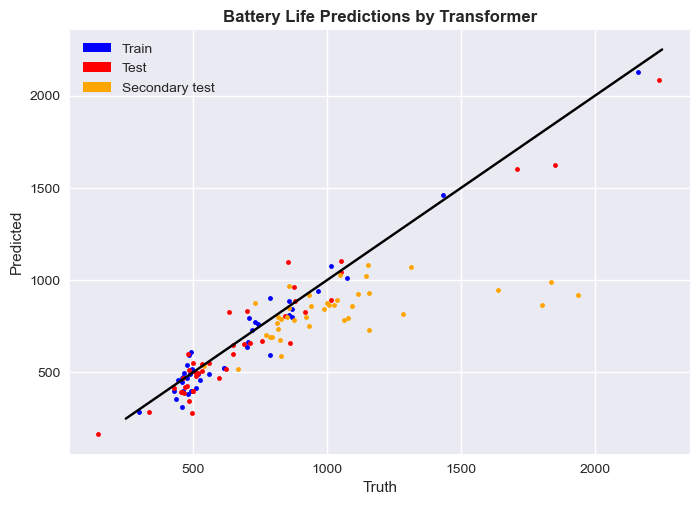

In [1064]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)